# Import Library

In [6]:
import pyiast
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
import os
import scipy.optimize as optim
import matplotlib.pyplot as plt

# Import Isotherm Fitting Data

In [7]:
basepath = os.getcwd()

In [8]:
os.chdir(basepath)
os.chdir('..')

df_NAME=pd.read_csv("HEAT_0413.csv")

bins_CO2 = []
bins_H2S = []
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb')
    bin_tmp = np.array(pickle.load(f_tmp))
    bins_CO2.append(bin_tmp[[False, True, True]]) ## Pick 1 = CO2, 2 = CH4 
    f_tmp.close()
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb') ## 0 = H2S , 1 = CO2, 2 = CH4
    bin_tmp = np.array(pickle.load(f_tmp))
    bins_H2S.append(bin_tmp[[True, False, True]]) ## Pick 0 = H2S and 2 = CH4
    f_tmp.close()

Names_CO2=df_NAME["NAME"].to_numpy()
Names_H2S=df_NAME["NAME"].to_numpy()
dH_CO2 = np.array([df_NAME["CO2_Heat"], df_NAME["CH4_Heat"]]).T
dH_H2S = np.array([df_NAME["H2S_Heat"],df_NAME["CH4_Heat"]]).T

os.chdir(basepath)

In [9]:
print(len(Names_H2S))
print(len(bins_H2S))
print()
print(len(Names_CO2))
print(len(bins_CO2))

5
5

5
5


# Functions for Isotherms and Ideal PSA

In [10]:
Arrh = lambda T,dH ,T_ref: np.exp(-dH/8.3145*(1/T - 1/T_ref)) # Arrhenius equation (Clasius-Clapeyron Equation)

## Isothermal mixture isotherm
def iso_mix(P_par, T, iso_list, dH_list,Tref_list):
    P_norm = []
    for (p,dh,tref) in zip(P_par, dH_list,Tref_list):
        p_n = Arrh(T,dh,tref)*p 
        P_norm.append(p_n)
    P_norm_arr = np.array(P_norm)
    #print(P_norm_mat.T)
    if P_norm_arr.ndim > 1:
        for i in range(len(P_norm[0])):
            p_tmp = P_norm_arr[i,:]
            p_tmp[p_tmp<0.000001] = 0.000001
            q_IAST_tmp = pyiast.iast(p_tmp,
                                     iso_list,
                                     warningoff=True)
    else:
        try:
            p_tmp = P_norm_arr
            p_tmp[p_tmp<0.000001] = 0.000001
            #print(p_tmp)
            q_IAST_tmp = pyiast.iast(p_tmp,
                                    iso_list,
                                     warningoff=True)
        except:    
            try:
                #print('Initial guess error with P = ',P_par)
                x_IG = np.ones(len(p_tmp))/len(p_tmp)
                q_IAST_tmp = pyiast.iast(p_tmp,
                                        iso_list,adsorbed_mole_fraction_guess = x_IG,
                                        warningoff=True)
            except:
                try:
                    arg_min = np.argmin(p_tmp)
                    p_tmp[p_tmp<0.000001] = 0.000001
                    x_IG = 0.05*np.ones(len(p_tmp))
                    x_IG[arg_min] = 1 - 0.05*(len(p_tmp)-1)
                    #print(x_IG)
                    q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                except:
                    try:
                        arg_max = np.argmax(p_tmp)
                        p_tmp[p_tmp<0.000001] = 0.000001
                        x_IG = 0.05*np.ones(len(p_tmp))
                        x_IG[arg_max] = 1 - 0.05*(len(p_tmp)-1)
                        #print(x_IG)
                        q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                    except:
                        try:
                            arg_max = np.argmax(p_tmp)
                            p_tmp[p_tmp<0.000001] = 0.000001
                            x_IG = 0.15*np.ones(len(p_tmp))
                            x_IG[arg_max] = 1 - 0.15*(len(p_tmp)-1)
                            #print(x_IG)
                            q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)
                        except:
                            try:
                                arg_min = np.argmin(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_min] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                            except:
                                try:
                                    arg_max = np.argmax(p_tmp)
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = 0.01*np.ones(len(p_tmp))
                                    x_IG[arg_max] = 1 - 0.01*(len(p_tmp)-1)
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                                except:
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = [0.9999, 0.0001]
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)    
           
    return q_IAST_tmp

In [11]:
def sat_fraction(y_lead,q_lead_array, y_follow,q_follow_array):
    q_sat_lead_part, q_sat_lead_tot, q_des_lead = q_lead_array
    q_sat_fo, q_des_fo = q_follow_array
    numo = y_follow*(q_sat_lead_part - q_des_lead)+y_lead*q_des_fo
    denom = y_follow*(q_sat_lead_part - q_sat_lead_tot)+y_lead*q_sat_fo
    sat_frac = numo/denom
    return sat_frac

In [12]:
def x2x(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    iso_1 = iso_input[0] # Heavy (CO2 or H2S)
    iso_2 = iso_input[1] # Methane (CH4)
    iso  = [iso_1,iso_2]
    dH_1, dH_2 = dH_input[:2]         # (kJ/mol): Heat of adsorption
    dH = np.array([dH_1,dH_2])*1000    # (J/mol): Heat of adsorption 
    P_low_part = np.array(x_ini)*P_low      # (bar): partial pressure
    P_high_part = np.array(yfeed)*P_high    # (bar): partial pressure
    ### Uptakes
    #print(P_low_part)
    P_low_part = np.reshape(P_low_part,len(iso))
    q_des = iso_mix(P_low_part,Tfeed,iso,
                    dH,Tref_input)
    #print(P_high_part)
    P_high_part = np.reshape(P_high_part,len(iso))
    q_sat_tot = iso_mix(P_high_part,Tfeed,iso,
                        dH,Tref_input)
    Dq_tot = q_sat_tot-q_des
    ### Leading component ?
    sat_extent = np.array(yfeed)/Dq_tot # Saturation extent kg/mol
    ind_lead_tot = np.argmax(sat_extent)
    dq = q_sat_tot - q_des
    x_out = dq/(np.sum(dq))
    return x_out,ind_lead_tot


In [13]:

def rec(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    def x_err(xx):
        x_new,_ = x2x([xx, 1-xx],P_high,P_low,
                           iso_input, dH_input, Tref_input, 
                           yfeed,Tfeed)
        return (xx-x_new[0])**2
    #sol = optim.minimize(x_err,x_ini,method='COBYLA')
    sol = optim.least_squares(x_err,x_ini,bounds = [0,1])
    x_sol = sol.x
    _,i_lead = x2x([x_sol, 1- x_sol],P_high,P_low,
                   iso_input, dH_input, Tref_input, 
                   yfeed,Tfeed)
    #if i_lead  < 0.5:
    #    return -1
    Recovery = 1-(1-x_sol)/x_sol*yfeed[0]/yfeed[1]
    if Recovery < 0 or Recovery > 1:
        Recovery = 1-x_sol/(1-x_sol)*yfeed[1]/yfeed[0]
    return Recovery, i_lead, x_sol
  #  return x_sol, i_lead, x_sol
    

# Find the Target Adsorbent

In [14]:
for i in range(len(Names_CO2)):
    print(i, Names_CO2[i])

0 AEL-0
1 IWR-1
2 LTL-2
3 MOR-1
4 SEW-1


In [30]:
print(Names_CO2[0])
print(Names_CO2[4])

AEL-0
SEW-1


In [47]:
ind_targ = 0# AEL0: index = 0
bins_targ_CO2 = bins_CO2[ind_targ]
bins_targ_H2S = bins_H2S[ind_targ]

dH_targ_CO2 = dH_CO2[ind_targ]
dH_targ_H2S = dH_H2S[ind_targ]

Name_targ = Names_CO2[ind_targ]

# Import GCMC Data

In [18]:
os.chdir(basepath)
df_targ = pd.read_csv('GCMC_AEL_CO2_CH4.csv')

In [19]:
df_targ

,P,CO2,CH4
0,0.0001,0.000010,0.000014
1,0.0005,0.000043,0.000045
2,0.0010,0.000097,0.000111
3,0.0100,0.001125,0.000801
4,0.0200,0.002099,0.001656
5,0.0300,0.003065,0.002554
6,0.0400,0.003968,0.003292
7,0.0500,0.005206,0.004133
8,0.0600,0.006028,0.004877
9,0.0700,0.007113,0.006002


In [20]:
p_gcmc_targ = df_targ['P'].to_numpy()

#q_h2s_gcmc_targ = df_targ['q_H2S'].to_numpy()
q_co2_gcmc_targ = df_targ['CO2'].to_numpy()

q_ch4_0_gcmc_targ = df_targ['CH4'].to_numpy()
#q_ch4_1_gcmc_targ = df_targ['q_CH4_withH2S'].to_numpy()

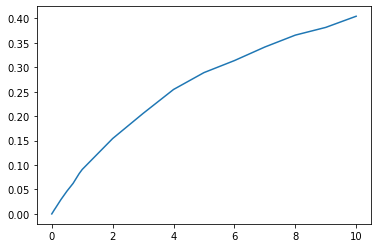

In [21]:
#plt.plot(p_gcmc_targ, q_h2s_gcmc_targ)
plt.plot(p_gcmc_targ, q_co2_gcmc_targ)

# IAST results vs GCMC results

## CO2

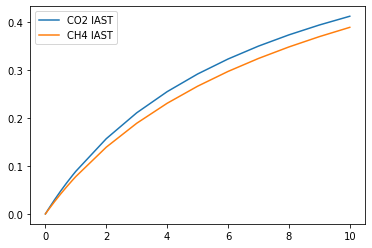

In [22]:
T_test = 343
q_co2_iast_targ = []
for pp in p_gcmc_targ:
    iast_res_tmp = iso_mix(np.array([0.5,0.5])*pp,T_test, bins_targ_CO2,dH_targ_CO2*1000, [298.15,298.15])
    q_co2_iast_targ.append(iast_res_tmp)
q_co2_iast_targ = np.array(q_co2_iast_targ)

plt.plot(p_gcmc_targ, q_co2_iast_targ[:,0], label = 'CO2 IAST')
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,1], label = 'CH4 IAST')

plt.legend()


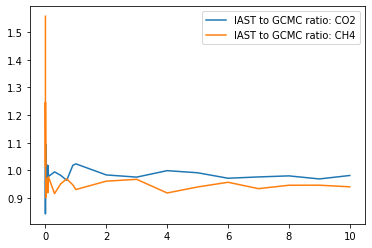

In [34]:
## Ratio of gcmc to IAST
plt.plot(p_gcmc_targ, q_co2_gcmc_targ/ q_co2_iast_targ[:,0] ,
        label = 'IAST to GCMC ratio: CO2') # CO2
plt.plot(p_gcmc_targ,q_ch4_0_gcmc_targ /  q_co2_iast_targ[:,1] ,
        label = 'IAST to GCMC ratio: CH4') # CH4

plt.legend() 

# BEFORE (CO2)

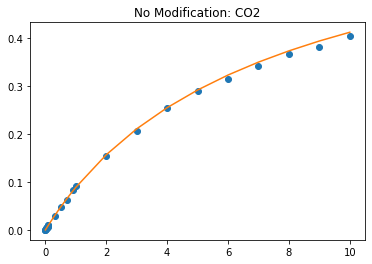

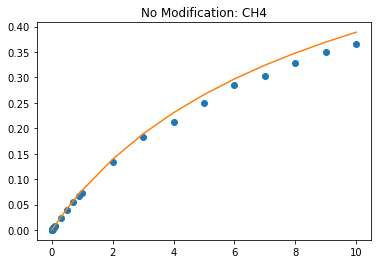

In [35]:
plt.figure()
plt.title('No Modification: CO2')
plt.plot(p_gcmc_targ, q_co2_gcmc_targ, 'o')
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,0])

plt.figure()
plt.title('No Modification: CH4')
plt.plot(p_gcmc_targ, q_ch4_0_gcmc_targ, 'o')
#plt.plot(p_gcmc_targ, q_co2_iast_targ[:,1]*5.5*p_gcmc_targ/(1+6*p_gcmc_targ))
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,1])

# AFTER (CO2)

### Roughly

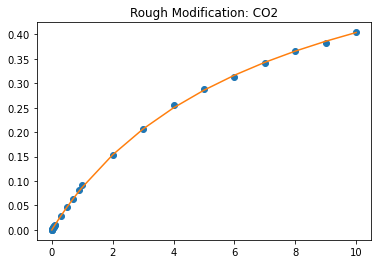

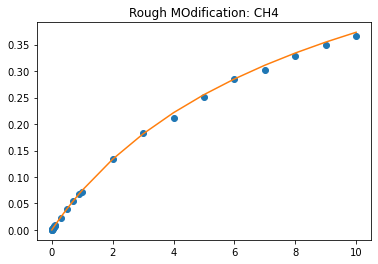

In [38]:
plt.figure()
plt.title('Rough Modification: CO2')
plt.plot(p_gcmc_targ, q_co2_gcmc_targ, 'o')
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,0]*0.98)

plt.figure()
plt.title('Rough MOdification: CH4')
plt.plot(p_gcmc_targ, q_ch4_0_gcmc_targ, 'o')
#plt.plot(p_gcmc_targ, q_co2_iast_targ[:,1]*5.5*p_gcmc_targ/(1+6*p_gcmc_targ))
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,1]*0.96)

### More Accurately

In [39]:
def f_modi_co2(kk):
    ret_tmp = kk
    return ret_tmp
def obj_targ_co2(k):
    #diff = q_co2_gcmc_targ - q_co2_iast_targ[:,0]*k
    diff = q_co2_gcmc_targ - q_co2_iast_targ[:,0]*f_modi_co2(k)
    return np.sum(diff**2)
#print(obj_targ_co2(1/1.47))
k_list = np.linspace(0.6,0.7)
#for kkk in k_list:
#    print(kkk)
#    print(obj_targ_co2(kkk))
#    print()
opt_res_co2 = optim.least_squares(obj_targ_co2, 0.65)
#opt_res_co2 = optim.least_squares(obj_targ_co2, [1.11,1.5,1.3])
print(opt_res_co2)
print('SUCCESS ? ')
print(opt_res_co2.success)




 active_mask: array([0.])
        cost: 4.044088828436737e-09
         fun: array([8.99342963e-05])
        grad: array([-4.55852235e-09])
         jac: array([[-5.0687252e-05]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 13
        njev: 11
  optimality: 4.558522345424183e-09
      status: 1
     success: True
           x: array([0.9795974])
SUCCESS ? 
True


In [40]:
def f_modi_ch4_0(kk):
    ret_tmp = kk
    #ret_tmp = kk[2] - (kk[0]*p_gcmc_targ/(1+kk[1]*p_gcmc_targ))
    #ret_tmp = (kk[0]*p_gcmc_targ/(1+kk[1]*p_gcmc_targ))
    #ret_tmp = kk[2]/(p_gcmc_targ+kk[0]) + kk[1]
    return ret_tmp

def obj_targ_ch4_0(k):
    diff = q_ch4_0_gcmc_targ - q_co2_iast_targ[:,1]*f_modi_ch4_0(k)
    return np.sum(diff**2)
#print(obj_targ_co2(1/1.47))
k_list = np.linspace(0.6,0.7)
#for kkk in k_list:
#    print(kkk)
#    print(obj_targ_co2(kkk))
#    print()
opt_res_ch4_0 = optim.least_squares(obj_targ_ch4_0, 0.85)
#opt_res_ch4_0 = optim.least_squares(obj_targ_ch4_0, [0.7,1.15])
#opt_res_ch4_0 = optim.least_squares(obj_targ_ch4_0, [0.7,0.8, 0.8])
print(opt_res_ch4_0)


 active_mask: array([0.])
        cost: 4.464173688903377e-09
         fun: array([9.44899327e-05])
        grad: array([6.54640815e-09])
         jac: array([[6.92815411e-05]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 11
        njev: 9
  optimality: 6.546408151930551e-09
      status: 1
     success: True
           x: array([0.94339434])


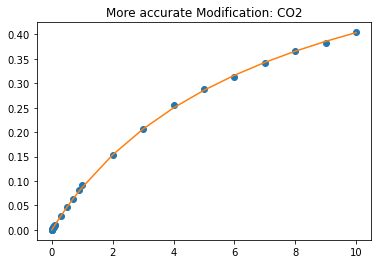

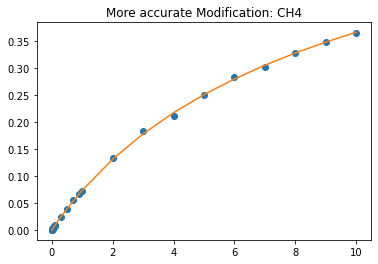

In [41]:
plt.figure()
plt.title('More accurate Modification: CO2')
plt.plot(p_gcmc_targ, q_co2_gcmc_targ, 'o')
#M_co2 = opt_res_co2.x[0]
#K_co2 = opt_res_co2.x[1]
#f_modi = M_co2 * p_gcmc_targ/(1+ K_co2*p_gcmc_targ)
m_modi_co2 = f_modi_co2(opt_res_co2.x)
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,0]*m_modi_co2)

plt.figure()
plt.title('More accurate Modification: CH4')
plt.plot(p_gcmc_targ, q_ch4_0_gcmc_targ, 'o')
#M_co2 = opt_res_co2.x[0]
#K_co2 = opt_res_co2.x[1]
#f_modi = M_co2 * p_gcmc_targ/(1+ K_co2*p_gcmc_targ)
#f_modi_ch4_0 = opt_res_ch4_0.x
m_modi_ch4_0 = f_modi_ch4_0(opt_res_ch4_0.x)
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,1]*m_modi_ch4_0)

# Plot in Jaehoon Style

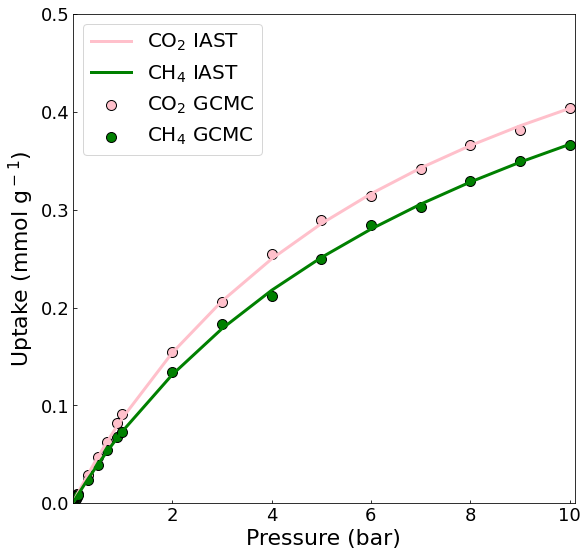

In [42]:
font_size=22

plt.figure(figsize=(9,9))
plt.tick_params(direction='in',labelsize=18)
 
plt.ylim([0,0.5])
plt.xlim([0.0001,10.1])

### PLOT
## CO2 IAST modi
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,0]*m_modi_co2,
         c='pink',lw='3',alpha=1,zorder=2,label='CO$_2$ IAST')
## CH4 IAST modi
plt.plot(p_gcmc_targ, q_co2_iast_targ[:,1]*m_modi_ch4_0,
         c='g',lw='3',alpha=1,zorder=2,label='CH$_4$ IAST')
## CO2 GCMC
plt.scatter(p_gcmc_targ, q_co2_gcmc_targ ,
            c='pink',edgecolors='k',s=100,alpha=1,zorder=2,label='CO$_2$ GCMC')
## CH$ GCMC
plt.scatter(p_gcmc_targ, q_ch4_0_gcmc_targ,c='g',
            edgecolors='k',s=100,alpha=1,zorder=2,label='CH$_4$ GCMC')


plt.xlabel(r"Pressure (bar)",fontsize=font_size)
plt.ylabel(r"Uptake (mmol g$^-$$^1$)",fontsize=font_size)

plt.legend(loc='upper left',fontsize=20)
#plt.savefig('./LTL-2.png',dpi=700)

plt.show()



# Functions AGAIN

## iso_mix_new

In [43]:
Arrh = lambda T,dH ,T_ref: np.exp(-dH/8.3145*(1/T - 1/T_ref)) # Arrhenius equation (Clasius-Clapeyron Equation)

## Isothermal mixture isotherm
def iso_mix_new(P_par, T, iso_list, dH_list,Tref_list):
    P_norm = []
    for (p,dh,tref) in zip(P_par, dH_list,Tref_list):
        p_n = Arrh(T,dh,tref)*p 
        P_norm.append(p_n)
    P_norm_arr = np.array(P_norm)
    #print(P_norm_mat.T)
    if P_norm_arr.ndim > 1:
        for i in range(len(P_norm[0])):
            p_tmp = P_norm_arr[i,:]
            p_tmp[p_tmp<0.000001] = 0.000001
            q_IAST_tmp = pyiast.iast(p_tmp,
                                     iso_list,
                                     warningoff=True)
    else:
        try:
            p_tmp = P_norm_arr
            p_tmp[p_tmp<0.000001] = 0.000001
            #print(p_tmp)
            q_IAST_tmp = pyiast.iast(p_tmp,
                                    iso_list,
                                     warningoff=True)
        except:    
            try:
                #print('Initial guess error with P = ',P_par)
                x_IG = np.ones(len(p_tmp))/len(p_tmp)
                q_IAST_tmp = pyiast.iast(p_tmp,
                                        iso_list,adsorbed_mole_fraction_guess = x_IG,
                                        warningoff=True)
            except:
                try:
                    arg_min = np.argmin(p_tmp)
                    p_tmp[p_tmp<0.000001] = 0.000001
                    x_IG = 0.05*np.ones(len(p_tmp))
                    x_IG[arg_min] = 1 - 0.05*(len(p_tmp)-1)
                    #print(x_IG)
                    q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                except:
                    try:
                        arg_max = np.argmax(p_tmp)
                        p_tmp[p_tmp<0.000001] = 0.000001
                        x_IG = 0.05*np.ones(len(p_tmp))
                        x_IG[arg_max] = 1 - 0.05*(len(p_tmp)-1)
                        #print(x_IG)
                        q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                    except:
                        try:
                            arg_max = np.argmax(p_tmp)
                            p_tmp[p_tmp<0.000001] = 0.000001
                            x_IG = 0.15*np.ones(len(p_tmp))
                            x_IG[arg_max] = 1 - 0.15*(len(p_tmp)-1)
                            #print(x_IG)
                            q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)
                        except:
                            try:
                                arg_min = np.argmin(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_min] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                            except:
                                try:
                                    arg_max = np.argmax(p_tmp)
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = 0.01*np.ones(len(p_tmp))
                                    x_IG[arg_max] = 1 - 0.01*(len(p_tmp)-1)
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                                except:
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = [0.9999, 0.0001]
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)    
    q_IAST_tmp = np.array([0.9865893*q_IAST_tmp[0],
                           0.977627*q_IAST_tmp[1]])       
    return q_IAST_tmp

## x2x_new

In [44]:
def x2x_new(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    iso_1 = iso_input[0] # Heavy (CO2 or H2S)
    iso_2 = iso_input[1] # Methane (CH4)
    iso  = [iso_1,iso_2]
    dH_1, dH_2 = dH_input[:2]         # (kJ/mol): Heat of adsorption
    dH = np.array([dH_1,dH_2])*1000    # (J/mol): Heat of adsorption 
    P_low_part = np.array(x_ini)*P_low      # (bar): partial pressure
    P_high_part = np.array(yfeed)*P_high    # (bar): partial pressure
    ### Uptakes
    #print(P_low_part)
    P_low_part = np.reshape(P_low_part,len(iso))
    q_des = iso_mix_new(P_low_part,Tfeed,iso,
                    dH,Tref_input)
    #print(P_high_part)
    P_high_part = np.reshape(P_high_part,len(iso))
    q_sat_tot = iso_mix_new(P_high_part,Tfeed,iso,
                        dH,Tref_input)
    Dq_tot = q_sat_tot-q_des
    ### Leading component ?
    sat_extent = np.array(yfeed)/Dq_tot # Saturation extent kg/mol
    ind_lead_tot = np.argmax(sat_extent)
    dq = q_sat_tot - q_des
    x_out = dq/(np.sum(dq))
    return x_out,ind_lead_tot

## rec_new

In [45]:
def rec_new(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    def x_err(xx):
        x_new,_ = x2x_new([xx, 1-xx],P_high,P_low,
                           iso_input, dH_input, Tref_input, 
                           yfeed,Tfeed)
        return (xx-x_new[0])**2
    #sol = optim.minimize(x_err,x_ini,method='COBYLA')
    sol = optim.least_squares(x_err,x_ini,bounds = [0,1])
    x_sol = sol.x
    _,i_lead = x2x_new([x_sol, 1- x_sol],P_high,P_low,
                   iso_input, dH_input, Tref_input, 
                   yfeed,Tfeed)
    Recovery = 1-(1-x_sol)/x_sol*yfeed[0]/yfeed[1]
    if Recovery < 0 or Recovery > 1:
        Recovery = 1-x_sol/(1-x_sol)*yfeed[1]/yfeed[0]
    return Recovery, i_lead, x_sol

# RUN CO2 VSA

## PREVIOUS VSA

In [50]:
#P_h_range = np.arange(2.5,50.1,0.5)
P_l_range = np.logspace(-3,np.log10(0.5))
T_feed_in = 343         # (K) temperature or 298K
T_tri = [298.15,]*2
#y_feed_in = np.array([0.83356,0.1644])
y_meth = 5/10
#y_ethy = 0.83356
y_feed_in = np.array([1-y_meth,y_meth])
Rec_list_set = []
leading_index_set = []
xx_list_set = []
Popt_CO2_list = []
#Pl_list = np.linspace(0.004,0.5,30)

Rec_list = []
leading_index = []
xx_list = []
x_guess = np.array([0.8,0.2])
for pl in P_l_range:
    rec_tmp,l_ind,x_tmp = rec(x_guess[0], 1,pl,
                              bins_targ_CO2, dH_targ_CO2, T_tri,y_feed_in, T_feed_in)
    Rec_list.append(rec_tmp)
    leading_index.append(l_ind)
    xx_list.append(x_tmp)
Rec_list_set.append(Rec_list)
leading_index_set.append(leading_index)

x_max = np.max(xx_list)

print(Name_targ)

AEL-0


12.810896964669983


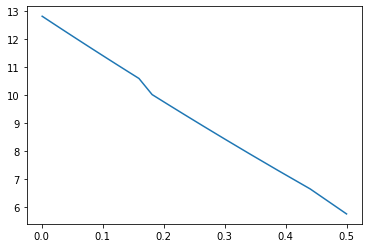

In [56]:
plt.plot(P_l_range,np.array(Rec_list)*100)
print(np.max(Rec_list)*100)

## NEW VSA

In [57]:
#P_h_range = np.arange(2.5,50.1,0.5)
P_l_range = np.logspace(-3,np.log10(0.5))
T_feed_in = 343         # (K) temperature or 298K
T_tri = [298.15,]*2
#y_feed_in = np.array([0.83356,0.1644])
y_meth = 5/10
#y_ethy = 0.83356
y_feed_in = np.array([1-y_meth,y_meth])
Rec_list_set = []
leading_index_set = []
xx_list_set = []
Popt_CO2_list = []
#Pl_list = np.linspace(0.004,0.5,30)

Rec_list = []
leading_index = []
xx_list = []
x_guess = np.array([0.5,0.5])
for pl in P_l_range:
    rec_tmp,l_ind,x_tmp = rec_new(x_guess[0], 1,pl,
                              bins_targ_CO2, dH_targ_CO2, T_tri,y_feed_in, T_feed_in)
    Rec_list.append(rec_tmp)
    leading_index.append(l_ind)
    xx_list.append(x_tmp)
Rec_list_set.append(Rec_list)
leading_index_set.append(leading_index)

x_max = np.max(xx_list)

print(Name_targ)

AEL-0


12.66741367479155


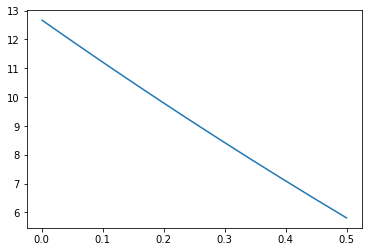

In [59]:
plt.plot(P_l_range, np.array(Rec_list)*100)
print(np.max(Rec_list)*100)